In [121]:
# Dependencies
import os
import pathlib
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.stats as stats
from uszipcode import SearchEngine


# Import the API key
from config import geoapify_key


DATA CLEANUP

1. The first set of data was obtained from the OpenBreweryAPI. The API is a free API, however it limits the number of queries to 200 rows and restricting sourcing of data to 2 pages at a time. In order to source all necessary data, it was necessary to create a loop to move through all 156 pages of the API and collect 100 cases per page or 200 every two pages. 

In [3]:
# URL for GET requests to retrieve brewery data
base_url = 'https://api.openbrewerydb.org/v1/breweries?by_country=United_States'


# Define an empty list to fetch the page data for each set of data
brewery_data = []

# Loop through the pages to get all the data
for page in range(1, 156):
    query_url = base_url + "&page="+ str(page) + "&per_page=200"
    response = requests.get(query_url).json()
    brewery_data.append(response)

# Create a list of all the breweries
breweries = []
for page in brewery_data:
    for brewery in page:
        breweries.append(brewery)

# Create a dataframe from the list of breweries
breweries_df = pd.DataFrame(breweries)

breweries_df.head()


,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,micro,1716 Topeka St,None,None,Norman,Oklahoma,73069-8224,United States,-97.46818222,35.25738891,4058160490,http://www.405brewing.com,Oklahoma,1716 Topeka St
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,micro,407 Radam Ln Ste F200,None,None,Austin,Texas,78745-1197,United States,None,None,5129211545,http://www.512brewing.com,Texas,407 Radam Ln Ste F200
2,ef970757-fe42-416f-931d-722451f1f59c,10 Barrel Brewing Co,large,1501 E St,None,None,San Diego,California,92101-6618,United States,-117.129593,32.714813,6195782311,http://10barrel.com,California,1501 E St
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,large,62970 18th St,None,None,Bend,Oregon,97701-9847,United States,-121.281706,44.08683531,5415851007,http://www.10barrel.com,Oregon,62970 18th St
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,None,None,Bend,Oregon,97703-2465,United States,-121.3288021,44.0575649,5415851007,None,Oregon,1135 NW Galveston Ave Ste B


It can be seen right away that the dataframe might be missing some values - the most importantly latitude and longitue which was important for maping visualizations. 

The describe function below shows that 2,392 rows are misisng the longitude and latitude. Since the number of rows consitutde 30% of the full data set, 
it was important to backfull the missing information.   

In [6]:
#creates a summary table of the data
breweries_df.describe()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
count,7936,7936,7936,7153,4,0,7936,7936,7936,7936,5544,5544,7141,6787,7936,7153
unique,7936,7791,10,7064,4,0,2908,54,7695,2,5433,5433,6950,6437,54,7064
top,5128df48-79fc-4f0f-8b52-d06be54d0cec,Granite City Food & Brewery,micro,303 Main St,Estacada,NaN,Portland,California,64108,United States,-112.0773456,33.4485866,5122442739,http://www.gcfb.net,California,303 Main St
freq,1,6,4115,3,1,NaN,105,912,5,7935,6,6,5,23,912,3


In [7]:
#Prepare the breweries Database for analysis 
#drop brevery id, address_2, address_3, country, phone, website_url, and street
clean_breweries_df = breweries_df.drop(columns=['id', 'address_2', 'address_3', 'country', 'phone', 'website_url', 'street'])
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon


Here's further confirmation that the necessary longtidue and latitude info is misisng in large numbers.   

In [8]:
#count missing values for each column
clean_breweries_df.isnull()
#count missing values for each column 
clean_breweries_df.isnull().sum()

# TEAM: We need to decide how to handle the missing values.  Do we drop the rows?

name                 0
brewery_type         0
address_1          783
city                 0
state_province       0
postal_code          0
longitude         2392
latitude          2392
state                0
dtype: int64

Decided to use Geopify to pull latitude and longtiude for the missing zip codes. Since Geopify did not recognize the postal code +4 format; 
opted to use the uszipcode package to extract the first 5 digits. While long/lat can be also pulled via uszipcode package, the exercise was to demonstrate the use of API for sourcing additional information. Using the package will also allow pulling additional information later.  

In [23]:
#create a new column in dataframe with first 5 digits of zip code ensuring the information is stored as stings & recognized as zipcodes.

search = SearchEngine()

def extract_zipcode(zipcode):
    # Remove +4 extension if present
    zipcode = zipcode.split('-')[0]
    zipcode_obj = search.by_zipcode(zipcode)
    if zipcode_obj is not None:
        return str(zipcode_obj.zipcode)[:5].zfill(5)
    else:
        return None

clean_breweries_df['zip_code'] = clean_breweries_df['postal_code'].apply(extract_zipcode).astype(str)

#add a ditinct ID number to each row 
clean_breweries_df['brewery_id'] = clean_breweries_df.index + 1
clean_breweries_df.head()


,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma,73069,1
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon,97703,5


In [10]:

#load dataframe into csv
clean_breweries_df.to_csv('breweries.csv', index=False)
#show count by the length of the postal code to see if there are any invalid postal codes
clean_breweries_df['zip_code'].str.len().value_counts()

5    7929
4       7
Name: zip_code, dtype: int64

In [11]:
#use dataframe from the csv breveries.csv
input_path = os.path.join("breweries.csv")
csv_breweries_df = pd.read_csv(input_path)

In [12]:
#Quick test if the API request url worked for a specific zip code
#postcode = "78745"
#target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
#response = requests.get(target_url).json()
#print(json.dumps(response, indent=4, sort_keys=True))


Creating a dataframe with missing information to temporarily separate from the clean of the data.

In [13]:
#extract rows with missing longitude and create a new dataframe - all longitude missing values correspond to missinging latitude values
missing_long_df = csv_breweries_df[csv_breweries_df['longitude'].isnull()]

#create a new dataframe with only the missing longitude rowsbased on clean_breweries_df
missing_long_df = clean_breweries_df[clean_breweries_df['longitude'].isnull()]

missing_long_df.head()


,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
18,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,None,None,New York,14221,19
19,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,None,None,Arizona,85296,20
24,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,None,None,Minnesota,55101,25
26,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,None,None,South Carolina,29687,27


In [14]:
#drop the missing_long dataframe into a csv file

missing_long_df.to_csv('breweries_missing_values.csv', index=False)


In [15]:

#use dataframe from the csv_breweries_missing_values.csv
input_path2 = os.path.join("breweries_missing_values.csv")
csv_breweries_missing_df = pd.read_csv(input_path2)


Finally demonstrate use of Geopify for obtianing missing information - encountered errors were bypassed with the try/except. 

In [19]:
#for missing longitude, use geopify to look up the longitude and latitude
for index, row in csv_breweries_missing_df.iterrows():
    postcode = row['zip_code']
    target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url)

    try:
        json_response = json.loads(response.text)
        if json_response:
            csv_breweries_missing_df.loc[index, 'longitude'] = json_response['results'][0]['lon']
            csv_breweries_missing_df.loc[index, 'latitude'] = json_response['results'][0]['lat']
            print(f"index: {index}, postcode: {postcode}, longitude: {json_response['results'][0]['lon']}, latitude: {json_response['results'][0]['lat']}") 

        else:
            print(f"Error: Empty JSON response for index {index}, postcode {postcode}")
    except IndexError:
        print(f"Error: IndexError occurred for index {index}, postcode {postcode}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON response for index {index}, postcode {postcode}")

csv_breweries_missing_df.head()

index: 0, postcode: 78745, longitude: -97.792614846, latitude: 30.208605656
index: 1, postcode: 14221, longitude: -78.729920877, latitude: 42.980952841
index: 2, postcode: 85296, longitude: -111.762518433, latitude: 33.335136701
index: 3, postcode: 55101, longitude: -93.088300242, latitude: 44.955919207
index: 4, postcode: 29687, longitude: -82.327800669, latitude: 34.991467109
index: 5, postcode: 27603, longitude: -78.66089377, latitude: 35.71301003
index: 6, postcode: 56442, longitude: -94.116315338, latitude: 46.677860236
index: 7, postcode: 05478, longitude: -73.104390267, latitude: 44.803484605
index: 8, postcode: 21157, longitude: -76.983937143, latitude: 39.558197671
index: 9, postcode: 22553, longitude: -77.60125509, latitude: 38.231176411
index: 10, postcode: 11741, longitude: -73.070358674, latitude: 40.794962148
index: 11, postcode: 05452, longitude: -73.08637315, latitude: 44.51595767
index: 12, postcode: 20109, longitude: -77.506105128, latitude: 38.784153209
index: 13, po

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


In [22]:
#save the dataframe with filled info into a csv file csv_breweries_missing_completed_df
csv_breweries_missing_df.to_csv('breweries_missing_completed.csv', index=False)
csv_breweries_missing_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


Independednt T-test - Zip with brewery & without 

DATA: 

In [581]:
#source merged brewery file with zip code census data
input_path = os.path.join("merged_zip.csv")
zip_breweries = pd.read_csv(input_path)

In [582]:
#show missing values for zip_breweries
zip_breweries.isnull().sum()
#drop rows with missing 'Nonfamily households:'
zip_breweries = zip_breweries.dropna(subset=['Nonfamily households:'])
#drop rows with missing 'Median household income
zip_breweries = zip_breweries.dropna(subset=['Median Income 12 mths '])

zip_breweries.head()



,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,...,Population Density per km2,Population Density per mile2,male_brew_age_%,TOTAL Brew Population Age Bracket population,male_brew_age,Median Income 12 mths,Total: - white households,"Male householder, no spouse present","Female householder, no spouse present",Nonfamily households:
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,...,670,259.0,0.21,10500,5478.0,28548.0,8647.0,430.0,835.0,4288.0
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,...,"3,091",1193.0,0.34,26729,16087.0,52980.0,18181.0,141.0,439.0,13110.0
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,...,51,20.0,0.22,17777,9339.0,37187.0,15310.0,827.0,1663.0,5986.0
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,...,"7,359",2841.0,0.29,12082,6666.0,56084.0,10748.0,177.0,216.0,8383.0
5,10 Barrel Brewing Co - Bend Pub,large,62950 NE 18th St,Bend,Oregon,97701,-121.280954,44.091211,Oregon,97701,...,51,20.0,0.22,17777,9339.0,37187.0,15310.0,827.0,1663.0,5986.0


In [583]:
zip_breweries.columns

Index(['name', 'brewery_type', 'address_1', 'city', 'state_province',
       'postal_code', 'longitude', 'latitude', 'state', 'zip_code',
       'brewery_id', 'Incomplete', 'Population  ',
       ' Population Density per km2 ', ' Population Density per mile2 ',
       'male_brew_age_%', ' TOTAL Brew Population Age Bracket population  ',
       'male_brew_age', 'Median Income 12 mths ', 'Total: - white households',
       'Male householder, no spouse present',
       'Female householder, no spouse present', 'Nonfamily households:'],
      dtype='object')

In [584]:
#source full census data file 
input_path2 = os.path.join("no_brew_zip.csv")
no_brew_zip = pd.read_csv(input_path2)
#drop missing rows with "Median Income" null
no_brew_zip = no_brew_zip.dropna(subset=['Median Income'])
no_brew_zip.head()


,Geographic Area Name,Geographic,Area,Zip,City,State,Total population,TOTAL Brew Population Age Bracket population,male_brew_age,male_brew_age_%,Median Income,Number of white households,"Male householder, no spouse present","Female householder, no spouse present",Nonfamily households:,density (km2),density(mil2)
132,ZCTA5 01001,ZCTA5,1001,1001.0,Agawam,MA,16984.0,6478.0,3618.0,0.213024,41359.0,6189,339,650,2485,550.1,212.0
133,ZCTA5 01003,ZCTA5,1003,1003.0,Amherst,MA,13253.0,85.0,66.0,0.004980,4453.0,10,0,0,0,6583.4,2542.0
134,ZCTA5 01008,ZCTA5,1008,1008.0,Blandford,MA,1317.0,382.0,212.0,0.160972,44531.0,497,9,53,176,7.4,3.0
135,ZCTA5 01009,ZCTA5,1009,1009.0,Bondsville,MA,980.0,398.0,229.0,0.233673,43233.0,333,26,29,143,442.8,171.0
136,ZCTA5 01010,ZCTA5,1010,1010.0,Brimfield,MA,3711.0,1302.0,813.0,0.219078,42369.0,1345,27,99,436,40.6,16.0


ANALYSIS: 

INDEPENDENT T-TEST - comparison of all zip-codes to zip codes with with micro & brepub brewery locations. 

Before test application, the dataset was filtered down to compare zip codes with micro & brew pub brewery types.  

In [604]:
#drop rows from the zip_breweries with brewery that is NOT micro or pub and rename the dataframe
zip_breweries_micro = zip_breweries[zip_breweries['brewery_type'].isin(['micro', 'brewpub'])]

The set was then tested for the shape if the distribution for Medium Income variable in both sets of zip codes - with & without breweries. 

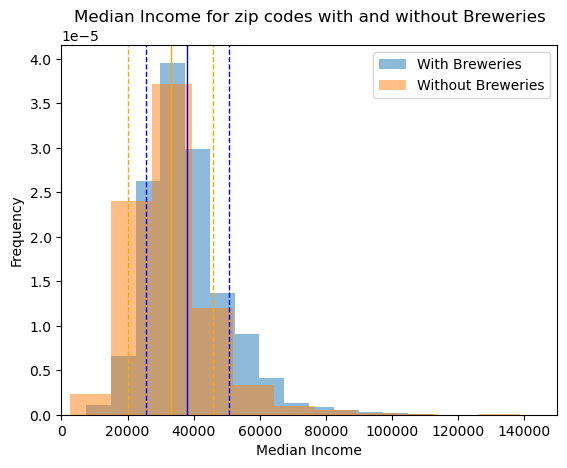

In [605]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro['Median Income 12 mths '], alpha=0.5, label='With Breweries', bins=20, density=True)
plt.hist(no_brew_zip['Median Income'], alpha=0.5, label='Without Breweries', bins=20, density=True)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean() + zip_breweries_micro['Median Income 12 mths '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean() + no_brew_zip['Median Income'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro['Median Income 12 mths '].mean() - zip_breweries_micro['Median Income 12 mths '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip['Median Income'].mean() - no_brew_zip['Median Income'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Median Income for zip codes with and without Breweries')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

#limit x axis to 0 to 150000
plt.xlim(0, 150000)

plt.legend()
plt.show()


Both distributions were normal, with areas with brewery location zip codes leaning toward the higher income areas. 

In [606]:
#find the mean of the median income for zip_breweries and no_brew_zip round to 2 decimal places
mean_with_breweries = round(zip_breweries_micro['Median Income 12 mths '].mean())
mean_without_breweries = round(no_brew_zip['Median Income'].mean())

#compute absolute difference between the two means with 2 decimal places

absolute_difference = round(abs(mean_with_breweries - mean_without_breweries))

print("Mean with breweries: $", mean_with_breweries)
print("Mean without breweries: $", mean_without_breweries)
print("Mean Absolute difference: $", absolute_difference)

print("---------------------------------------------------")

median_with_breweries = zip_breweries_micro['Median Income 12 mths '].median()
print("Median with breweries: $", median_with_breweries)
median_without_breweries = no_brew_zip['Median Income'].median()
print("Median without breweries: $", median_without_breweries)

absolute_difference_median = round(abs(median_with_breweries - median_without_breweries))
print("Median Absolute difference: $", absolute_difference_median)

Mean with breweries: $ 38100
Mean without breweries: $ 33059
Mean Absolute difference: $ 5041
---------------------------------------------------
Median with breweries: $ 35921.0
Median without breweries: $ 31250.0
Median Absolute difference: $ 4671


In [607]:
zip_breweries['Median Income 12 mths '] = zip_breweries_micro['Median Income 12 mths '].astype(float)
no_brew_zip['Median Income'] = no_brew_zip['Median Income'].astype(float)
#run an independednt t-test for the median income of zip codes with breweries and zip codes without breweries
stats.ttest_ind(zip_breweries_micro['Median Income 12 mths '], no_brew_zip['Median Income'], equal_var=False)
#run an independednt t-test for the median age of zip codes with breweries and zip codes without breweries
#stats.ttest_ind(zip_breweries['Median Age'], no_brew_zip['Median Age'], equal_var=False)


Ttest_indResult(statistic=27.587155939972227, pvalue=1.0600259801014812e-160)

The t-test confirmed that the median income difference between the two sets of zipcodes is statistically different. 

In [608]:
mean_difference = zip_breweries['Median Income 12 mths '].mean() - no_brew_zip['Median Income'].mean()
pooled_std = np.sqrt((zip_breweries_micro['Median Income 12 mths '].std()**2 + no_brew_zip['Median Income'].std()**2) / 2)

cohen_d = mean_difference / pooled_std

print("Cohen's d:", cohen_d)

Cohen's d: 0.3978458087054


Overall, the two zip codes with and without breweries differed and the difference was statistically significant but the difference was modest. In absolute terms, the difference between the median income was $5,040. It would be benefitional to further explore different income brackets to confirm if the zip code income brackets and distribution of brewery locations show any preference i.e. median income between 70-150,0000 being the prefered location.       

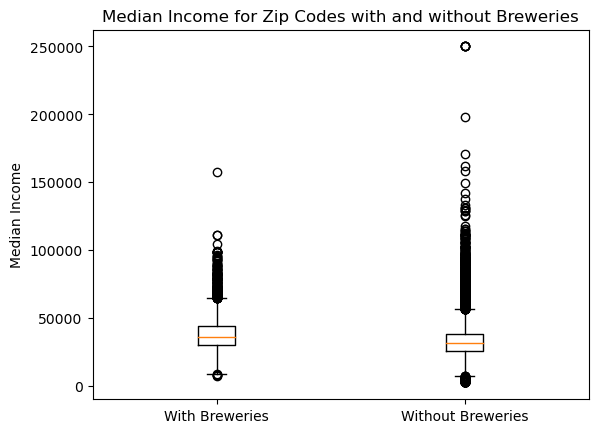

In [609]:
#plot boxplot to show the data comparing the two populations
plt.boxplot([zip_breweries_micro['Median Income 12 mths '], no_brew_zip['Median Income']], labels=['With Breweries', 'Without Breweries'])
plt.title('Median Income for Zip Codes with and without Breweries')
plt.ylabel('Median Income')
plt.show()


Words of caution relating to the number of outliers in the set. Both areas with breweries and without had a significnat number of zip codes with median income far outside of the range. It would be benefitial to further review the outlier sets in search of further differentiaing characteristics and possible relationships between the variables. 

__________________________________________________________________________________

COMPARISON of male population in 25-39 age bracket for zip codes with and without breweries.  

In [610]:
# Drop rows in zip_breweries_micro dataframe where male_brew_age column value is empty
zip_breweries_micro_males = zip_breweries.dropna(subset=['male_brew_age_%'])
no_brew_zip_males = no_brew_zip.dropna(subset=['male_brew_age_%'])

#show row count for the sets
print("Zip codes with breweries: " + str(len(zip_breweries_micro_males)))
print("Zip codes without breweries: " + str(len(no_brew_zip_males)))


Zip codes with breweries: 7061
Zip codes without breweries: 25836


In [611]:
# Find the mean of male population for zip_breweries and no_brew_zip
median_with_breweries_males = zip_breweries_micro_males['male_brew_age_%'].median() * 100
mean_with_breweries_males = zip_breweries_micro_males['male_brew_age_%'].mean() * 100
median_without_breweries_males = no_brew_zip_males['male_brew_age_%'].median() * 100
mean_without_breweries_males = no_brew_zip_males['male_brew_age_%'].mean() * 100

# Compute absolute difference between the two means
absolute_difference_males = abs(mean_with_breweries_males - mean_without_breweries_males)

print("_________________________________________________________________________________________________________________________________________________________")

print("Comparison of mean and median of the target population as a proportion of the total population for zip codes with and without breweries:")
print("_________________________________________________________________________________________________________________________________________________________")

print("Mean male median age 25-39 population for zip codes with breweries: {:.2f}%".format(mean_with_breweries_males))
print("Mean male median age 25-39 population for zip codes without breweries: {:.2f}%".format(mean_without_breweries_males))
print("Absolute difference: {:.2f}%".format(absolute_difference_males))

print("---------------------------------------------------")

absolute_difference_males2 = abs(median_with_breweries_males - median_without_breweries_males)

print("Median male median age 25-39 population for zip codes with breweries: {:.2f}%".format(median_with_breweries_males))
print("Median male median age 25-39 population for zip codes without breweries: {:.2f}%".format(median_without_breweries_males))
print("Absolute difference: {:.2f}%".format(absolute_difference_males2))


_________________________________________________________________________________________________________________________________________________________
Comparison of mean and median of the target population as a proportion of the total population for zip codes with and without breweries:
_________________________________________________________________________________________________________________________________________________________
Mean male median age 25-39 population for zip codes with breweries: 21.51%
Mean male median age 25-39 population for zip codes without breweries: 21.18%
Absolute difference: 0.33%
---------------------------------------------------
Median male median age 25-39 population for zip codes with breweries: 21.00%
Median male median age 25-39 population for zip codes without breweries: 19.63%
Absolute difference: 1.37%


The mean and median of the population for the target group did not seem to differ between the two datasets. 

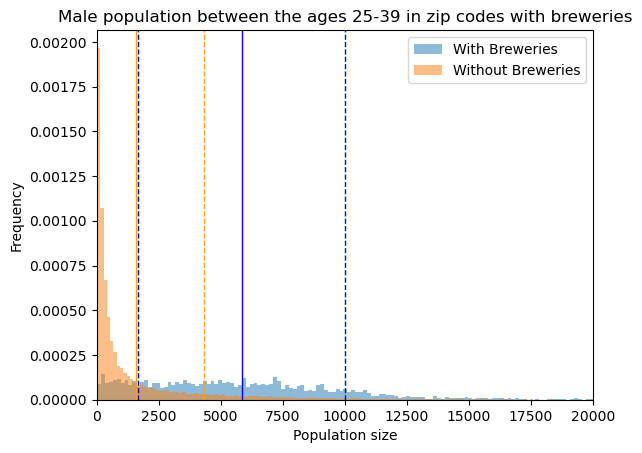

In [612]:
# plot a histogram showing the data comparing the two populations 'male_brew_age' using small markers
plt.hist(zip_breweries_micro_males['male_brew_age'], alpha=0.5, label='With Breweries', bins=200, density=True)
plt.hist(no_brew_zip_males['male_brew_age'], alpha=0.5, label='Without Breweries', bins=200, density=True)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean() + zip_breweries_micro_males['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean() + no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro_males['male_brew_age'].mean() - zip_breweries_micro_males['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_males['male_brew_age'].mean() - no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Male population between the ages 25-39 in zip codes with breweries')
plt.xlabel('Population size')
plt.ylabel('Frequency')

# limit x axis to 0 to 3000
plt.xlim(0, 20000)

plt.legend()
plt.show()


The histogram shows that the populations for the two data sets differ drastically. For the zip codes without breweries, male population is largery skewed toward the left side of the distribution. The distribution most likely reflects the fact that a large majority of the zip codes are sparsely populated. The low male population might be following the overal population trend in zip code spread. For the brewery data, the zip code data information is relatively flat and spread out flat relecting that the zip codes with breweries might be leaning heavier toward higher population areas aka smaller zip codes with higher population densities. However, based on this it also seems that while breweries stick to populated areas, they become less prevalent in very high population or target group population areas.    

The zipcode area can be considered a limitation when it comes to finding relationships between the two sets. The average size of a ZIP code area is roughly 90 square miles. However, the size of a ZIP code area can vary widely depending on the population density of the area. For example, ZIP code area 10028 in Manhattan is only 0.3 square miles (http://proximityone.com/zip_urban_rural.htm); further USPS does not limit the size of a ZIP code area. The codes based on geo location and population density. For exmaple, the lower the population density the larger the ZIP code area. The distribution above points seems to indicate that proportionally a large majority of zipcodes are very sparsely populated. 

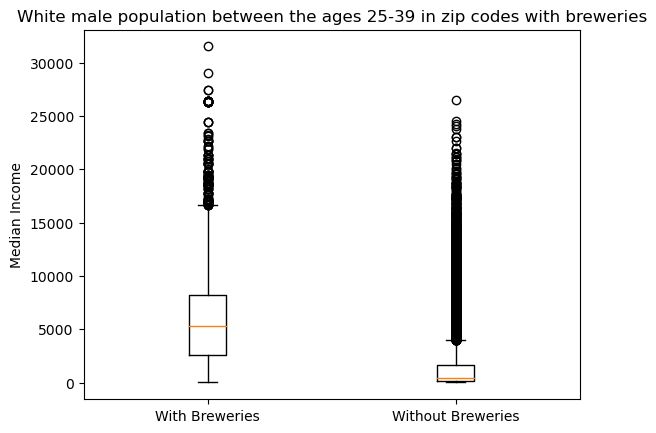

In [613]:
#plot boxplot to show the data comparing the two populations
plt.boxplot([zip_breweries_micro_males['male_brew_age'], no_brew_zip_males['male_brew_age']], labels=['With Breweries', 'Without Breweries'])
plt.title('White male population between the ages 25-39 in zip codes with breweries')
plt.ylabel('Median Income')
plt.show()

_____________________________________________________________________________________

Following previous population analysis we tried to further explore the relationship between population density and brewery locations. 

In [614]:
#drop rows in zip_breweries_micro dataframe where denisty per sq mile column value is empty

zip_breweries_micro_density = zip_breweries.dropna(subset=[' Population Density per mile2 '])

no_brew_zip_density = no_brew_zip.dropna(subset=['density(mil2)'])

In [615]:
#show row count for the sets
print("Zip codes with breweries: " + str(len(zip_breweries_micro_density)))
print("Zip codes without breweries: " + str(len(no_brew_zip_density)))

Zip codes with breweries: 7056
Zip codes without breweries: 25839


First - verified the skew to take  birds eye view on differences between the populations:

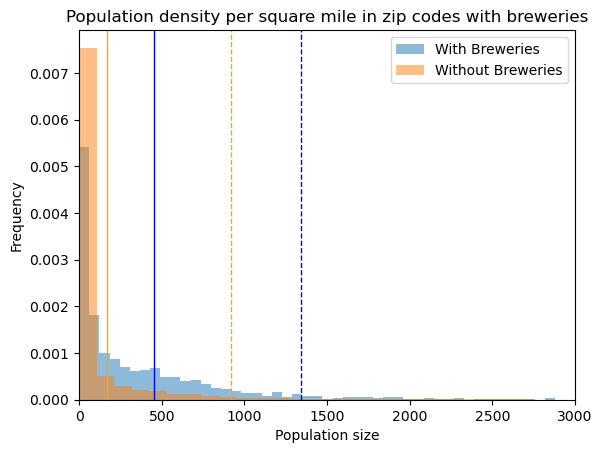

In [623]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro_density[' Population Density per mile2 '], alpha=0.5, label='With Breweries', bins=250, density=True)
plt.hist(no_brew_zip_density['density(mil2)'], alpha=0.5, label='Without Breweries', bins=250, density=True)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean() + zip_breweries_micro_density[' Population Density per mile2 '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean() + no_brew_zip_density['density(mil2)'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro_density[' Population Density per mile2 '].mean() - zip_breweries_micro_density[' Population Density per mile2 '].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density['density(mil2)'].mean() - no_brew_zip_density['density(mil2)'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Population density per square mile in zip codes with breweries')
plt.xlabel('Population size')
plt.ylabel('Frequency')

#limit x axis to 0 to 20000
plt.xlim(0, 3000)

plt.legend()
plt.show()


The skew of the data both in number of zipcodes with and without breweries follows the same pattern with the largest number of breweries being located in the 0-1000 population per square mile which is considered non-urban according to Census. Aproximately 65% of breweries are located in zipcodes with density of less than 400 people per square mile. 

When reviewing the map map of locations though, it is apparent that eventhough less populated, the brewery locations are largery condensed around the large metropolitan areas. The "tail" end, or the areas with density of over 1000 people per square mile, show that even though it is a smaller part of the set, remaining breweries are relatively spread out over more densly populated areas. 

The skew of dirtibution precludes use of the t-test to determine differences between the two sets. 

In [617]:
# provide summary statiistics fro both populations rouning the numbers to the integer
print("Summary statistics for zip codes with breweries")
print(zip_breweries_micro_density[' Population Density per mile2 '].describe())
print("Summary statistics for zip codes without breweries")
print(no_brew_zip_density['density(mil2)'].describe())


Summary statistics for zip codes with breweries
count     7056.000000
mean       454.821429
std        884.469882
min          0.000000
25%         36.000000
50%        178.000000
75%        556.000000
max      15324.000000
Name:  Population Density per mile2 , dtype: float64
Summary statistics for zip codes without breweries
count    25839.000000
mean       167.653740
std        752.602957
min          0.000000
25%          3.000000
50%          9.000000
75%         60.000000
max      26419.000000
Name: density(mil2), dtype: float64


Based on histogram review, we decided to further explore the higher density areas since then nuber of breweries per zip code still seems highest in proporion to the number of zip codes assigned to the higher population denisty areas. 

In [624]:
#delete rows with Population Density per mile2 less than 1000
zip_breweries_micro_density_high = zip_breweries_micro_density[zip_breweries_micro_density[' Population Density per mile2 '] > 400]
#delete rows with Population Density per mile2 less than 1000 from 
no_brew_zip_density_high = no_brew_zip_density[no_brew_zip_density['density(mil2)'] > 400]
#show row count for the sets
print("Zip codes with breweries: " + str(len(zip_breweries_micro_density_high)))
print("Zip codes without breweries: " + str(len(no_brew_zip_density_high)))


Zip codes with breweries: 2408
Zip codes without breweries: 2588


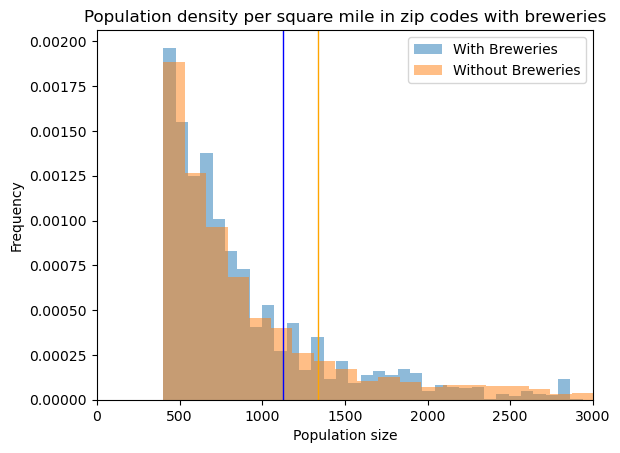

In [619]:
 # plot a histogram showing the data comparing the two populations using small markers
plt.hist(zip_breweries_micro_density_high[' Population Density per mile2 '], alpha=0.5, label='With Breweries', bins=200, density=True)
plt.hist(no_brew_zip_density_high['density(mil2)'], alpha=0.5, label='Without Breweries', bins=200, density=True)
plt.axvline(zip_breweries_micro_density_high[' Population Density per mile2 '].mean(), color='blue', linestyle='solid', linewidth=1)
plt.axvline(no_brew_zip_density_high['density(mil2)'].mean(), color='orange', linestyle='solid', linewidth=1)
plt.axvline(zip_breweries_micro_density_high[' Population Density per mile2 '].mean() + zip_breweries_micro_density_high['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density_high['density(mil2)'].mean() + no_brew_zip_males['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(zip_breweries_micro_density_high[' Population Density per mile2 '].mean() - zip_breweries_micro_density_high['male_brew_age'].std(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_brew_zip_density_high['density(mil2)'].mean() - no_brew_zip_density_high['male_brew_age'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Population density per square mile in zip codes with breweries')
plt.xlabel('Population size')
plt.ylabel('Frequency')

#limit x axis to 0 to 20000
plt.xlim(0, 3000)

plt.legend()
plt.show()

The data on density maintained a strong left skew and at a closer look seem to match almost exactly.  

In [620]:
#find the median of male population for zip_breweries and no_brew_zip round to 0 decimal places
mean_with_breweries_density_high = round(zip_breweries_micro_density_high[' Population Density per mile2 '].median(),0)
mean_without_breweries_density_high = round(no_brew_zip_density_high['density(mil2)'].median(),0)

#compute absolute difference between the two means with 2 decimal places

absolute_difference_density_high = round(abs(mean_with_breweries_density_high - mean_without_breweries_density_high),2)

print("Median population density per square mile in zip codes with breweries:", mean_with_breweries_density_high)
print("Median population density per square mile in zip codes without breweries:", mean_without_breweries_density_high)
print("Absolute difference:", absolute_difference_density_high)

Median population density per square mile in zip codes with breweries: 739.0
Median population density per square mile in zip codes without breweries: 744.0
Absolute difference: 5.0


In [621]:
#Verify if there is a significant difference between the two populations using Mann-Whitney U test

# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(zip_breweries_micro_density_high[' Population Density per mile2 '], no_brew_zip_density_high['density(mil2)'])

# Print the test statistic and p-value
print("p-value:", p_value)


p-value: 0.326102641397099


The p-value (0.3261) is greater than the typical significance level of 0.05, meaning that the more population dense the code, the fewer the zip_codes and proportionally the fewer breweries there are. Even though in general terms one would think that theoretically higher density zip-codes could have a higher brewery-opening potential, it looks like the density becomes a constraint in itself.     

LOGISTIC REGRESSION - ATTEMPT 

Index(['Geographic Area Name', 'Geographic', 'Area', 'Zip', 'City ', 'State',
       'Total population ', 'TOTAL Brew Population Age Bracket population ',
       'male_brew_age', 'Median Income', 'Number of white households',
       'Male householder, no spouse present',
       'Female householder, no spouse present', 'Nonfamily households:',
       'density (km2)', 'density(mil2)'],
      dtype='object')

INDEPENDENT T-TEST - comparison of a random 200 brewpub/micro of open breweries against the closed locations

Because the brewery dataset is very large and consists of over 7,000 rows, in order to check the difference between the two sets a smaller random set seems like a better solution. 

In [ ]:
#to limit issues with selection I opted for choosing the random 200 / wanting to avoid bias 
#decided to use a loop to run the suample multiple times 
#pick a random sample of 200 breweries from the zip_breweries_micro dataframe 
zip_breweries_micro_sample = zip_breweries_micro.sample(n=200, random_state=5)

# Assuming your large dataset is stored in a DataFrame called 'zip_breweries_micro_sample'
sample_size = 200  # Define the desired sample size
num_samples = 1000  # Define the number of random samples to take

sample_means = []  # To store the means of each random sample

for _ in range(num_samples):
    random_sample = zip_breweries_micro_sample.sample(n=sample_size, replace=True)
    sample_mean = random_sample['Median Income 12 mths '].mean()  # Calculate the mean of the column of interest
    sample_means.append(sample_mean)

average_mean_open = np.mean(sample_means)  # Calculate the average of the sample means

print("Average Mean:", average_mean_open)


Average Mean: 37361.69896


In [ ]:
#extract from brewery zip data frame brewery_type = closed and create a new dataframe
zip_breweries_micro_closed = zip_breweries[zip_breweries['brewery_type'] == 'closed']
#drop rows with missing medinan income from zip_breweries_micro_closed
zip_breweries_micro_closed = zip_breweries.dropna(subset=['Median Income 12 mths '])


In [ ]:
#first find the mean of the median income for the two groups to learn differences between the two absolute values

mean_closed_breweries = round(zip_breweries_micro_closed['Median Income 12 mths '].mean(),2)

#compute absolute difference between the two means with 2 decimal places

absolute_difference2 = round(abs(average_mean_open - mean_closed_breweries),2)

print("Mean for open breweries: $", average_mean_open)
print("Mean for closed breweries: $", mean_closed_breweries)
print("Absolute difference: $", absolute_difference2)

Mean for open breweries: $ 37361.69896
Mean for closed breweries: $ 38099.57
Absolute difference: $ 737.87


In [ ]:
#run an independednt t-test for the median income of zip codes were breweries closed
#stats.ttest_ind(zip_breweries_micro_closed['Median Income 12 mths '], average_mean_open, equal_var=False)